# 今回の取り組み

- Stx2の大型欠失において、補正が強めに出てしまったので対策します

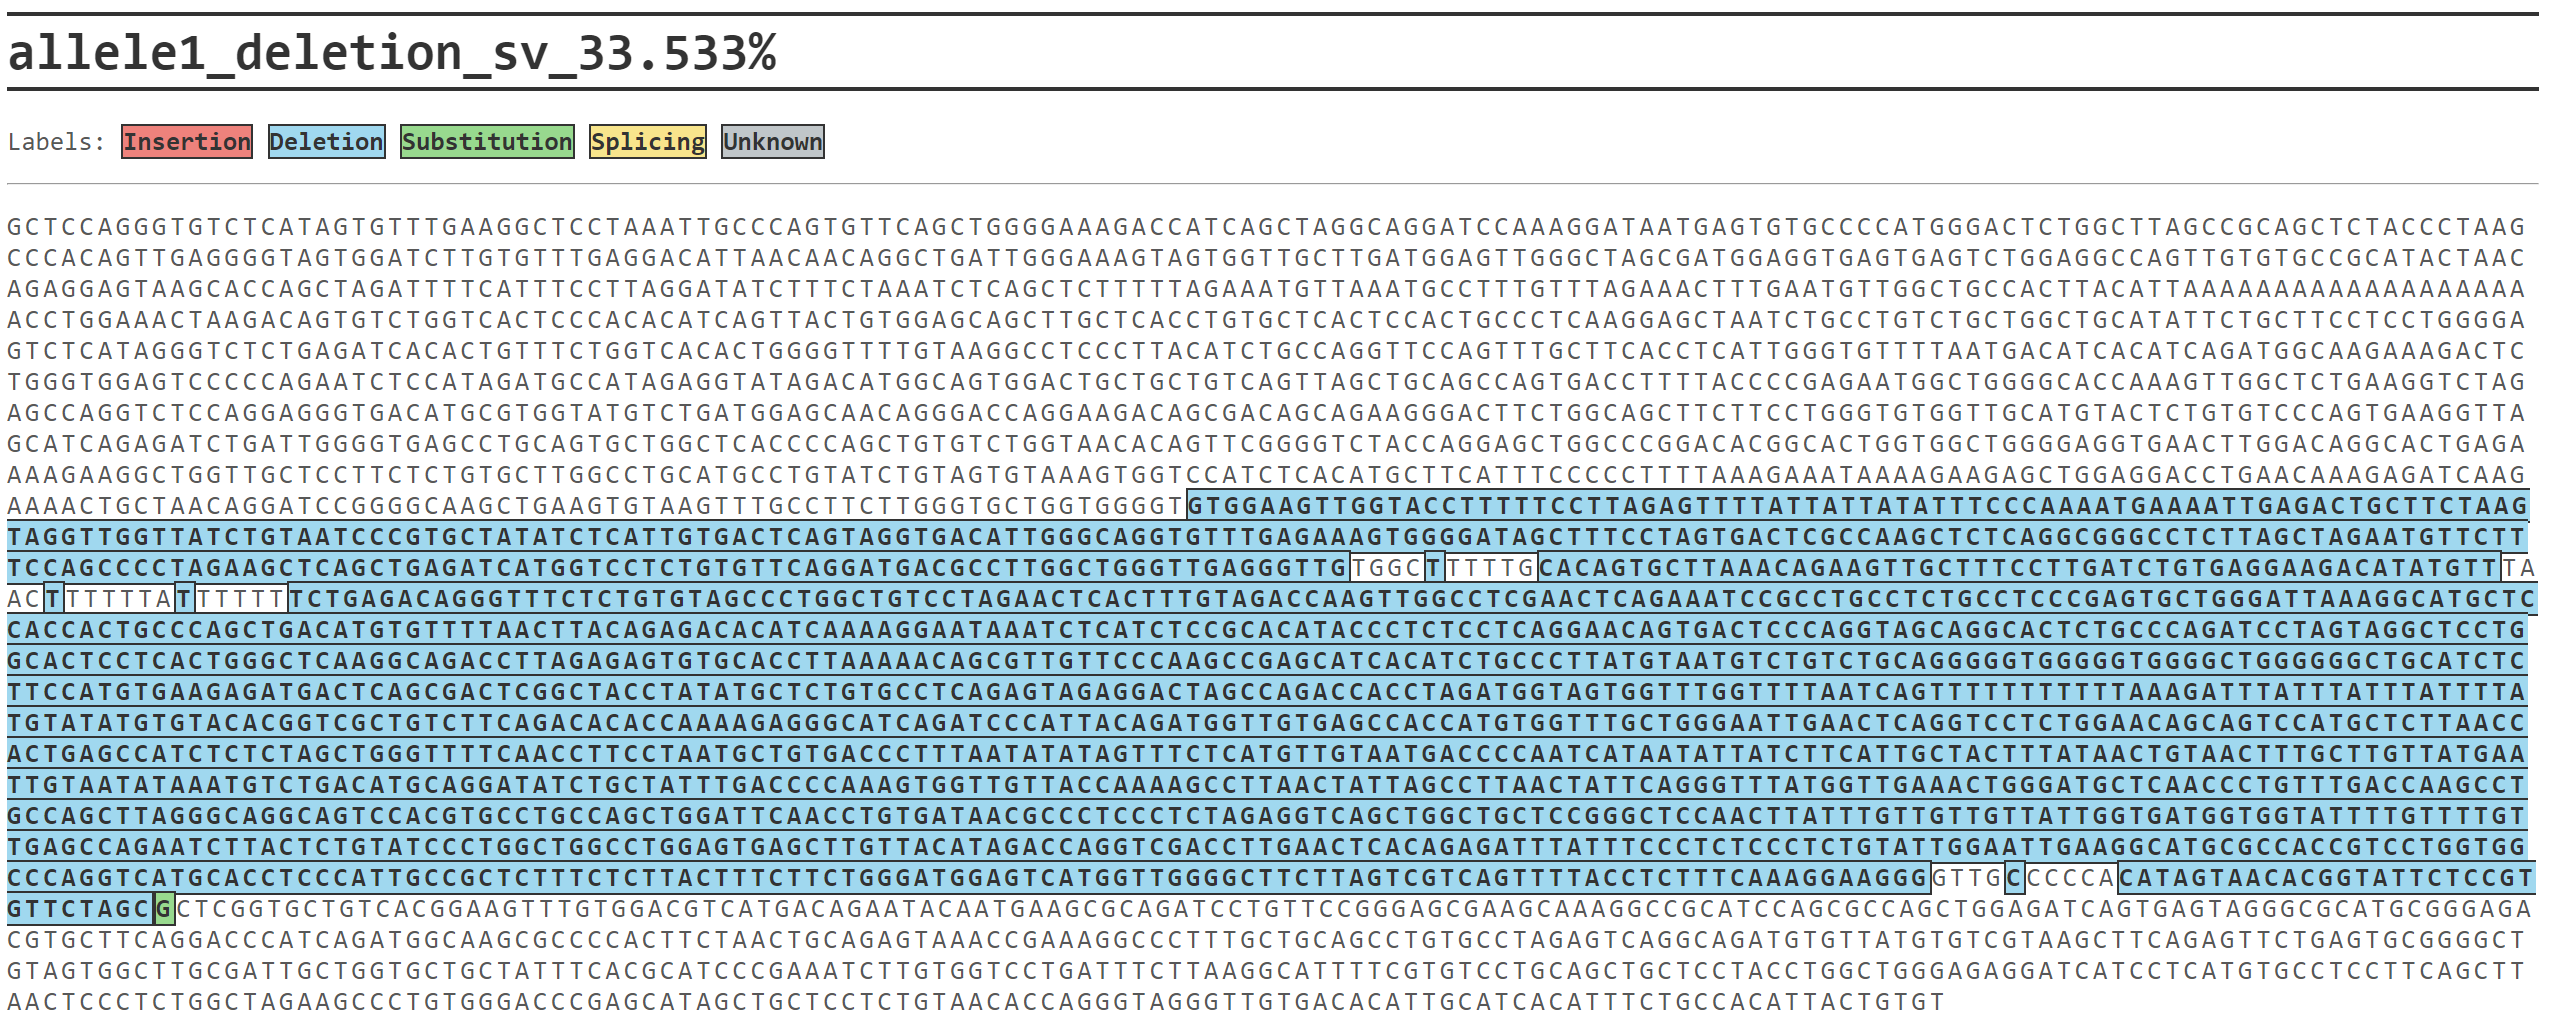

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

SAMPLE = preprocess.format_inputs.convert_to_posix_path(SAMPLE)
CONTROL = preprocess.format_inputs.convert_to_posix_path(CONTROL)
ALLELE = preprocess.format_inputs.convert_to_posix_path(ALLELE)

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-stx2deletion...


In [4]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [6]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [1] * len(transposed_cssplits),
            "del": [1] * len(transposed_cssplits),
            "sub": [1] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

# def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
#     count_indels_removed = dict()
#     threshold = coverage * 0.5 / 100 # 0.5%
#     for key, values in count_indels.items():
#         values_removed = [v if v >= threshold else 1 for v in values]
#         count_indels_removed.update({key: values_removed})
#     return count_indels_removed


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=10)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # 次の塩基が-1でない場合は、次の塩基を検証しない
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        cossim_pval_false = [cossim if pvalue > 0.05 else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _extract_mutation_loci(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    # Difference of anomaly within kmers
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [7]:
import midsv
allele = "deletion"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)

In [11]:
sequence = FASTA_ALLELES[allele]
idx_mutation = sequence.index("TGGCTTTTTG")
print(idx_mutation)
print(idx_mutation in mutation_loci["del"])
print(idx_mutation -1 in mutation_loci["del"])

1603
False
True


In [13]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
# Difference of anomaly within kmers
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})


In [16]:
print(idx_mutation in anomaly_loci["del"])
print(idx_mutation -1 in anomaly_loci["del"])
print(idx_mutation in dissimilar_loci["del"])
print(idx_mutation -1 in dissimilar_loci["del"])
print(idx_mutation in mutation_loci["del"])
print(idx_mutation -1 in mutation_loci["del"])

False
True
True
True
False
True


- `anomaly_loci`でFalseになっている！

In [19]:
key="del"
print(idx_mutation)
print(indels_kmer_sample[key][idx_mutation])
print(indels_kmer_control[key][idx_mutation])

1603
[511, 515, 528, 519, 526, 516, 536, 520, 524, 869]
[21, 18, 23, 23, 26, 18, 40, 32, 44, 365]


In [20]:
coverage_sample, coverage_control = len(cssplits_sample), len(cssplits_control)
values_control = np.array(indels_kmer_control[key]) / coverage_control
values_sample = np.array(indels_kmer_sample[key]) / coverage_sample

print(values_sample[idx_mutation])
print(values_control[idx_mutation])

[0.34066667 0.34333333 0.352      0.346      0.35066667 0.344
 0.35733333 0.34666667 0.34933333 0.57933333]
[0.02056807 0.01762977 0.02252693 0.02252693 0.02546523 0.01762977
 0.03917728 0.03134182 0.043095   0.35749265]


In [25]:
clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
clf.fit(values_control[idx_mutation].reshape(-1, 1))
pred = clf.predict(values_sample[idx_mutation].reshape(-1, 1))
print(pred)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


- `n_neighbers=10`だと、Controlにスコアが高い（ホモポリマー領域の欠失など）が一塩基でもあるとそれも考慮される
- `n_neighbers=5`などにして、Contorlにある外れ値をはずすと良いかもしれません

- `n_neighbers=5`にして、テストしてみます

In [27]:
%%bash
rm -rf DAJINResults/single-stx2deletion-n_neighbers5
rm -rf DAJINResults/.tempdir/single-stx2deletion-n_neighbers5

time DAJIN2 \
    --name single-stx2deletion-n_neighbers5 \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion-n_neighbers5 to see the report.

real	4m3.847s
user	49m50.879s
sys	3m54.312s


- 想定通り、欠失部位を描出できました！

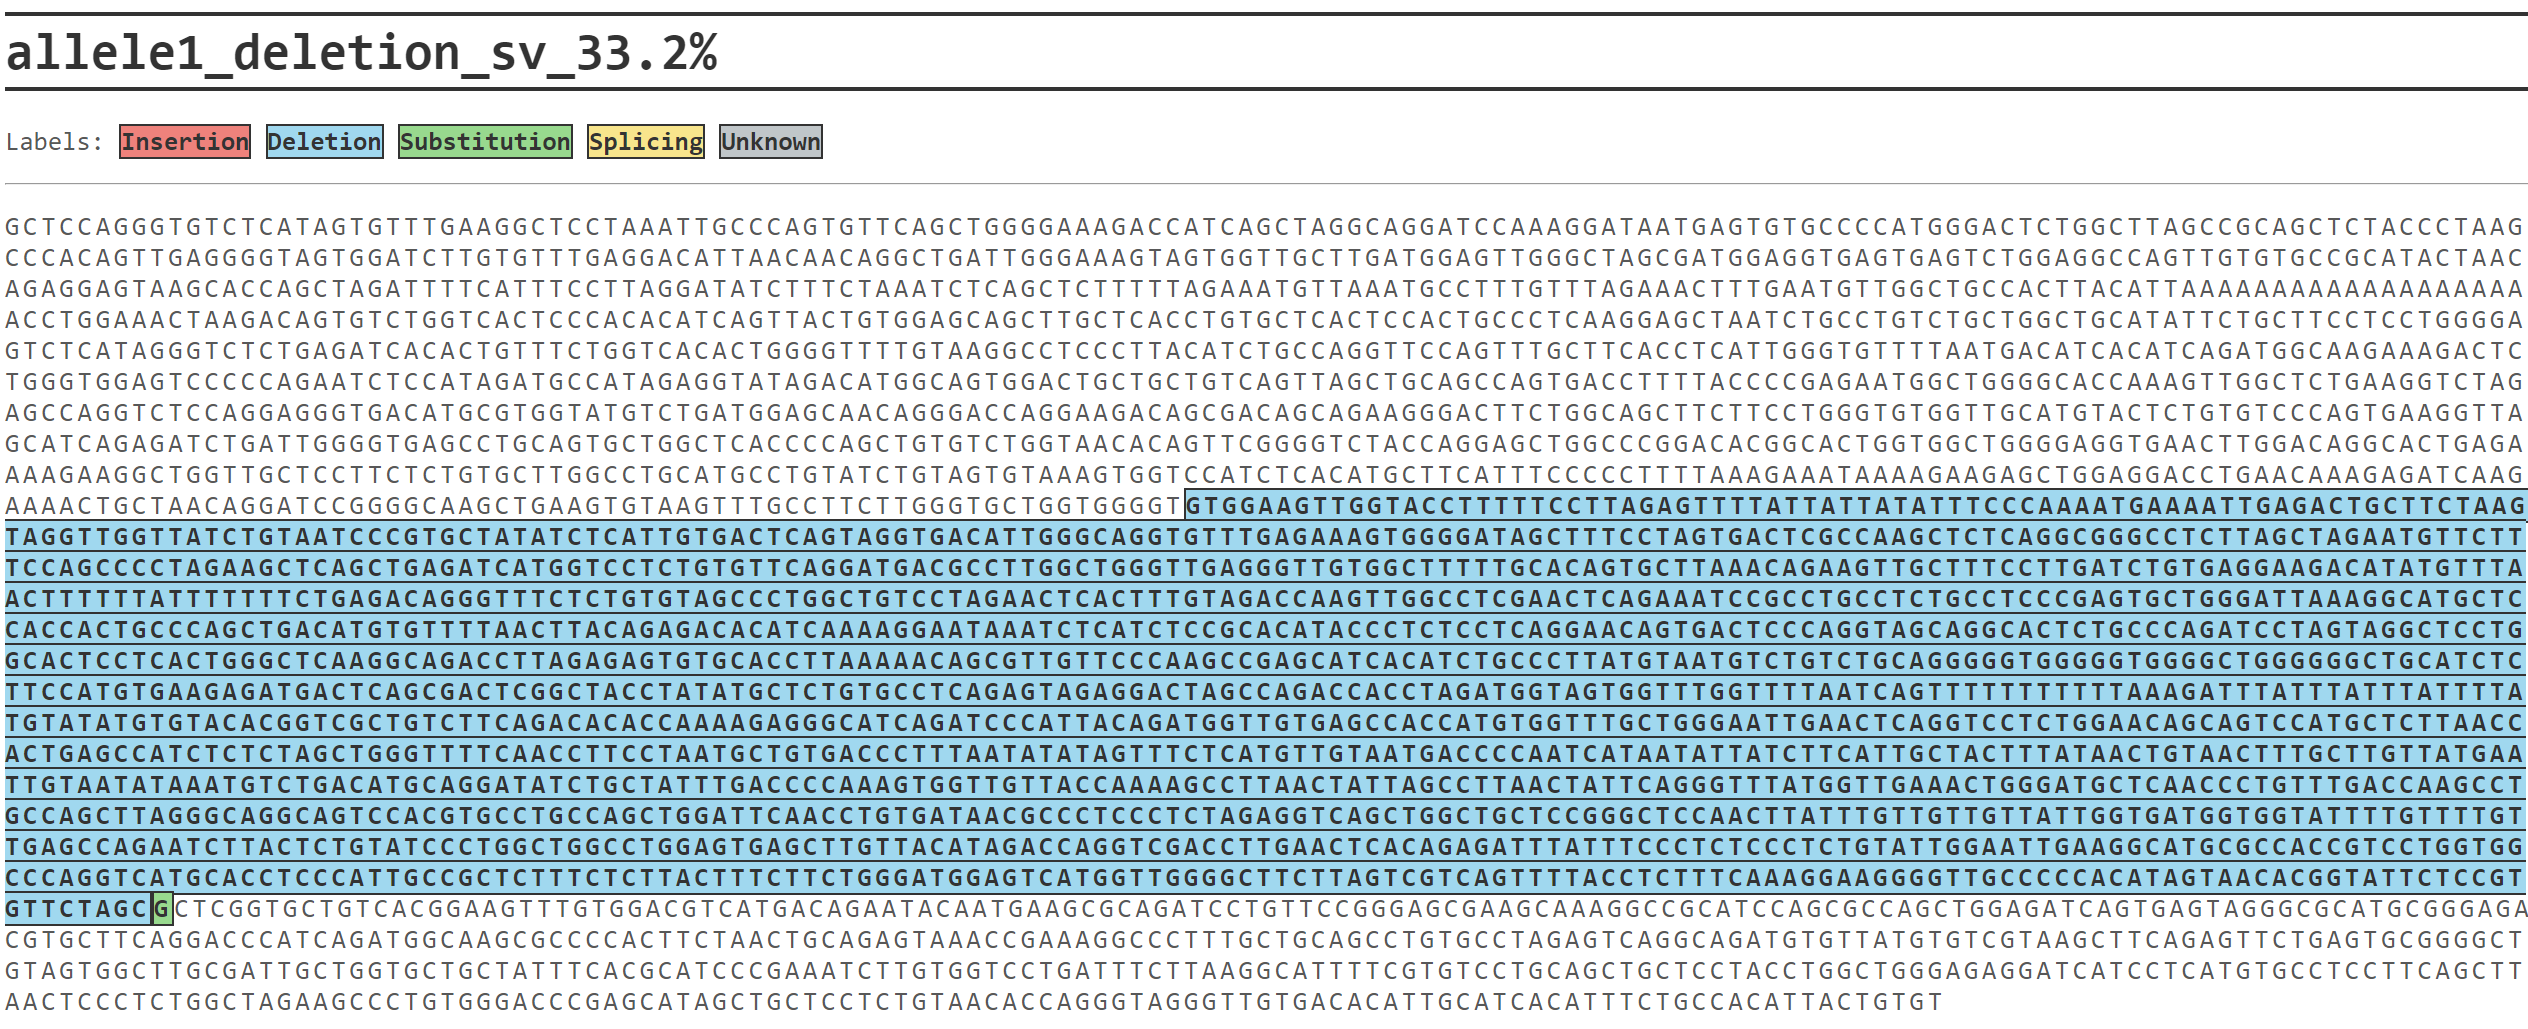

## 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `correct_sequence_error`のアルゴリズムを変更しました
  - 各kmerごとにLOFをかけることで、いい感じに異常検知ができるようになりました
    - **LOFのn_neighborsの値を10から5に変更することで、controlに含まれるホモポリマー領域の欠失を考慮しない異常検知ができるようになりました**
  - `_remove_minor_allele`を削除しました
  - `_count_indels`の挿入塩基を塩基長を考慮しない形にしました
      - もしかしたら、マイナーな挿入（1リードのみ）以外は塩基長を考慮したほうが良いかもしれません

- Tyrはいい感じでした
- Stx2に対して、補正が強く出ている箇所がありました
- AyabeTask1は改善が必要です
    - Floxはleft/right-loxpがなくなってしまいました

# 次に取り組むこと

- Tyrの動作確認
- ayabe-task1のleft/right-loxpの検出
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする